# Tuning text foundation models with Adapter Tuning

## Adapter Tuning in Vertex AI

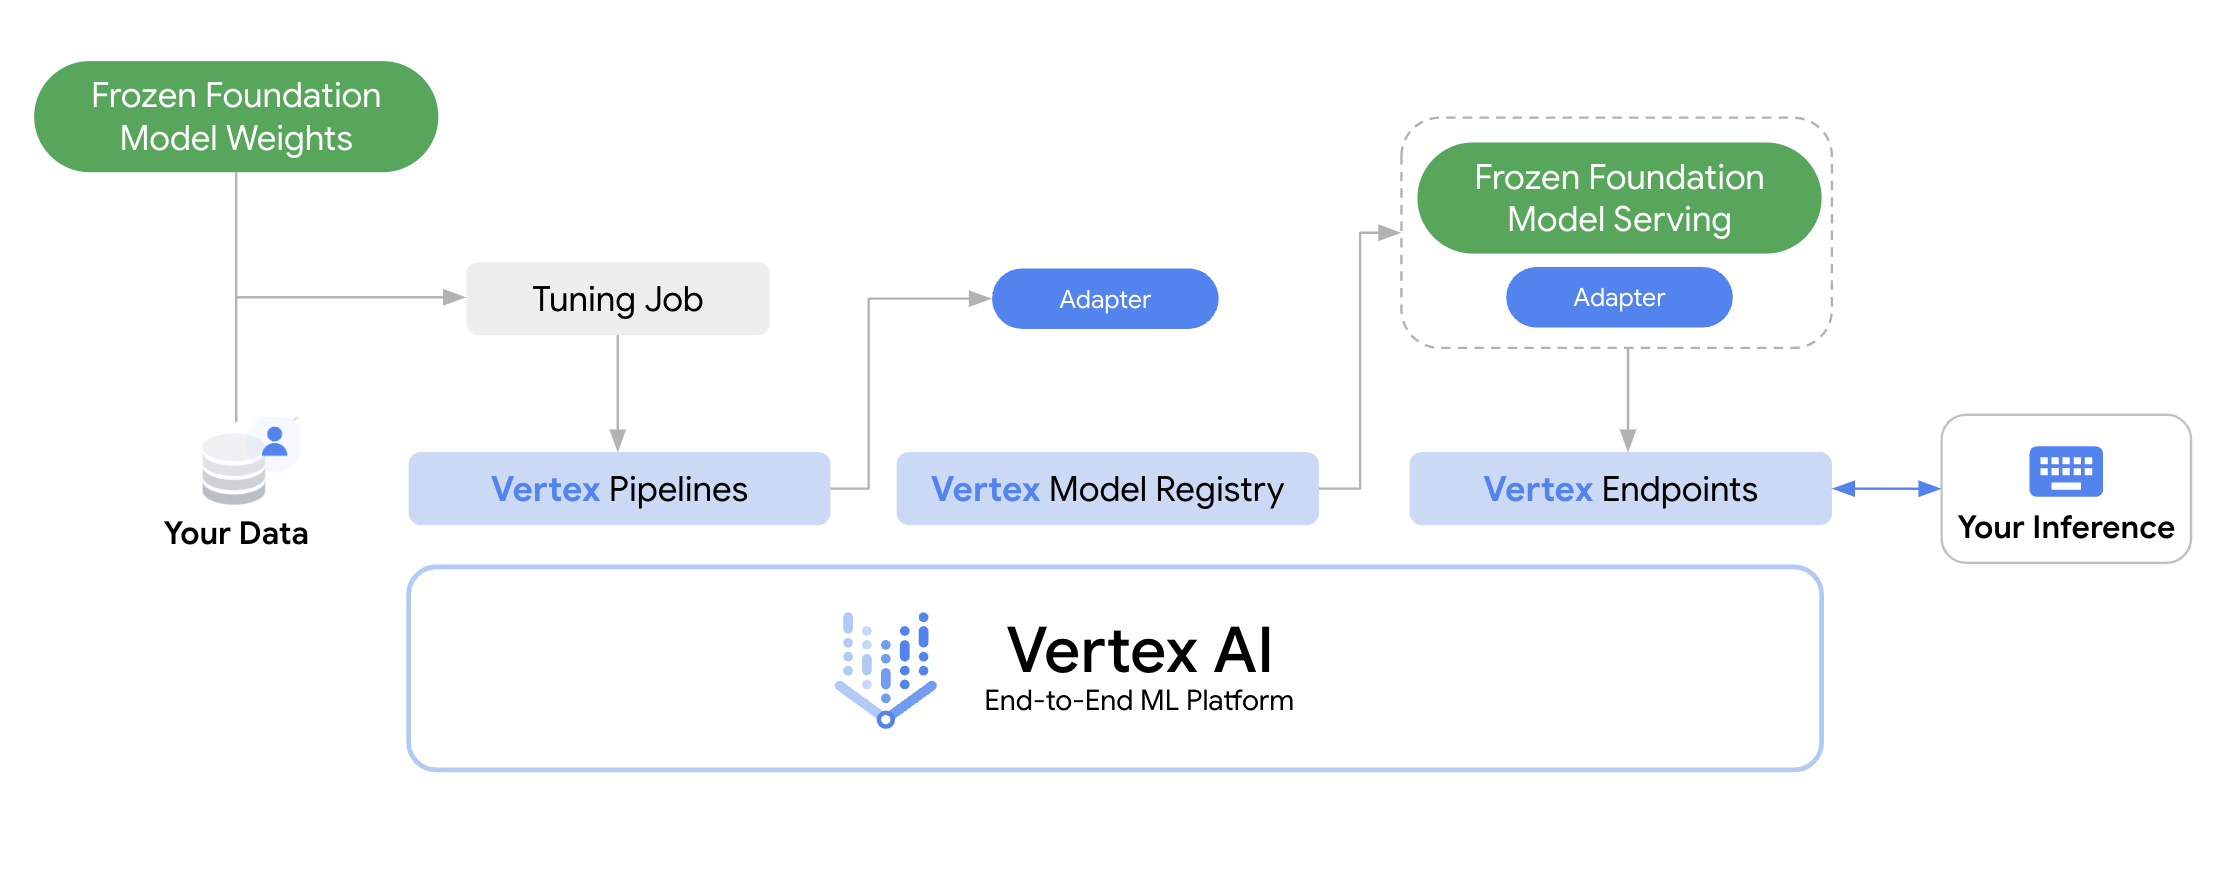

## Install pre-requisites

If running in Colab install the pre-requisites into the runtime. Otherwise it is assumed that the notebook is running in Vertex Workbench. In that case it is recommended to install the pre-requistes from a terminal using the `--user` option.

In [ ]:
import sys

if 'google.colab' in sys.modules:
    ! pip install -U google-cloud-aiplatform "shapely<2.0.0"
    ! pip install -U datasets evaluate

## Authenticate

If running in Colab authenticate with `google.colab.google.auth` otherwise assume that running on Vertex Workbench.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth as google_auth
    google_auth.authenticate_user()

## Import the required packages

In [7]:
import json
import pandas as pd
import vertexai

from google.cloud import aiplatform
from vertexai.preview.language_models import TextGenerationModel
from datasets import load_dataset, Dataset, DatasetDict

## Configure environment setttings

* `PROJECT_ID` - your GCP project ID
* `ENDPOINT_LOCATION` - a region where the the adapter endpoint will be deployed 
* `TUNING_JOB_LOCATION` - a region to run a tuning pipeline. Must be `europe-west4`
* `PIPELINE_ROOT_GCS_LOCATION` - a GCS location for storing tuning pipeline artifacts. Must be in the same region where the tuning job runs
* `DATA_STAGING_GCS_LOCATION` - a GCS location for training, validation, and test datasets

In [8]:
PROJECT_ID = "jk-mlops-dev"  # @param {type:"string"}
ENDPOINT_LOCATION = "us-central1"  # @param {type:"string"}
TUNING_JOB_LOCATION = "europe-west4" # @param {type:"string"}
PIPELINE_ROOT_GCS_LOCATION = 'gs://jk-staging-europe-west4/vertex-genai-tuning-examples/pipelines'
DATA_STAGING_GCS_LOCATION = 'gs://jk-vertex-us-central1/vertex-genai-tuning-examples/datasets'

### Initialize Vertex SKD

In [9]:
vertexai.init(project=PROJECT_ID, location=ENDPOINT_LOCATION)

### Create a Vertex AI TensorBoard instance

The Adapter Tuning pipeline can log the training metrics for tracking and retrospective analysis. 

Create an instance of Vertex AI Tensorboard that will be used by tuning pipeline runs. 

If you want to reuse an existing instance, skip the following cell and set the `tensorboard_id` variable to your instance ID. Note that the instance must be in the same region where the tuning jobs will run.

In [10]:
display_name = 'Adapter tuning - '

tensorboard = aiplatform.Tensorboard.create(
        display_name=display_name,
        project=PROJECT_ID,
        location=TUNING_JOB_LOCATION,
    )

print(tensorboard.display_name)
print(tensorboard.resource_name)

Adapter tuning - 
projects/895222332033/locations/europe-west4/tensorboards/548190109330046976


In [11]:
#tensorboard_id = tensorboard.resource_name.split('/')[-1]
#tensorboard_id = '5392374458520436736'
tensorboard_id = '548190109330046976'

## Prepare training dataset

In this lab, you are going to tune the **text-bison** foundation model for a single label text classification task. You are going to use the `dair-ai/emotion` dataset from HuggingFace. .

### Load the dataset

In [12]:
dataset = load_dataset('dair-ai/emotion')
print(dataset)
print(dataset['test'][0:2])

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
{'text': ['im feeling rather rotten so im not very ambitious right now', 'im updating my blog because i feel shitty'], 'label': [0, 0]}


In [13]:
splits = {k:v for (k,v) in zip(['train', 'validation', 'test'],
                                 load_dataset('dair-ai/emotion', split=['train[0:7200]', 'validation[0:256]', 'test[0:256]']))}
dataset = DatasetDict(splits)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 7200
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 256
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 256
    })
})

### Convert to the format required by the tuning pipeline

Your model tuning dataset must be in JSON Lines (JSONL) format where each line contains a single tuning example. Each example is composed of an `input_text` field that contains the prompt to the model and an `output_text` field that contains an example response that the tuned model is expected to produce. The maximum token length for input_text is 8,192 and the maximum token length for output_text is 1,024. If either fields exceed the maximum token length, the excess tokens are truncated.

The examples included in your dataset should match your expected production traffic. If your dataset contains specific formatting, keywords, instructions, or information, the production data should be formatted in the same way and contain the same instructions.

For example, if the examples in your dataset include a `"question:"` and a `"context:"`, production traffic should also be formatted to include a `"question:"` and a `"context:"` in the same order as it appears in the dataset examples. If you exclude the context, the model will not recognize the pattern, even if the exact question was in an example in the dataset.

For tasks such as classification, it is possible to create a dataset of examples that don't contain instructions. However, excluding instructions from the examples in the dataset leads to worse performance after tuning than including instructions, especially for smaller datasets.

For our dataset, we are going to add the following instructions

```
Classify the following as one of the following categories:
- sadness,
- joy,
Text:

In [14]:
class_labels = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

class_labels.values()

dict_values(['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [15]:
instructions = f'''Classify the following text into one of the following classes: 
[{', '.join(class_labels.values())}]
Text:
'''

def add_instructions(example, instructions):
    example["input_text"] = f'{instructions}{example["text"]}'
    example["output_text"] = class_labels[example["label"]]
    return example

tuning_dataset = dataset.map(lambda x: add_instructions(x, instructions)).remove_columns(['text', 'label'])

print(tuning_dataset)
print(tuning_dataset['train'][:1])

DatasetDict({
    train: Dataset({
        features: ['input_text', 'output_text'],
        num_rows: 7200
    })
    validation: Dataset({
        features: ['input_text', 'output_text'],
        num_rows: 256
    })
    test: Dataset({
        features: ['input_text', 'output_text'],
        num_rows: 256
    })
})
{'input_text': ['Classify the following text into one of the following classes: \n[sadness, joy, love, anger, fear, surprise]\nText:\ni didnt feel humiliated'], 'output_text': ['sadness']}


### Export the dataset splits to GCS

In [16]:
gcs_uris = {}
filename_prefix = 'emotion'

for split_name, split_data in tuning_dataset.items():
    jsonl_filename = f'{filename_prefix}-{split_name}.jsonl'
    gcs_uri = f'{DATA_STAGING_GCS_LOCATION}/{jsonl_filename}'
    gcs_uris[split_name] = gcs_uri
    split_data.to_json(jsonl_filename)
    !gsutil cp {jsonl_filename} {gcs_uri}

!gsutil ls {DATA_STAGING_GCS_LOCATION}

Creating json from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Copying file://emotion-train.jsonl [Content-Type=application/octet-stream]...
/ [1 files][  1.8 MiB/  1.8 MiB]                                                
Operation completed over 1 objects/1.8 MiB.                                      


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Copying file://emotion-validation.jsonl [Content-Type=application/octet-stream]...
/ [1 files][ 62.8 KiB/ 62.8 KiB]                                                
Operation completed over 1 objects/62.8 KiB.                                     


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Copying file://emotion-test.jsonl [Content-Type=application/octet-stream]...
/ [1 files][ 62.6 KiB/ 62.6 KiB]                                                
Operation completed over 1 objects/62.6 KiB.                                     
gs://jk-vertex-us-central1/vertex-genai-tuning-examples/datasets/batch_inputs.json
gs://jk-vertex-us-central1/vertex-genai-tuning-examples/datasets/emotion-evaluation.json
gs://jk-vertex-us-central1/vertex-genai-tuning-examples/datasets/emotion-test.jsonl
gs://jk-vertex-us-central1/vertex-genai-tuning-examples/datasets/emotion-train.jsonl
gs://jk-vertex-us-central1/vertex-genai-tuning-examples/datasets/emotion-validation.jsonl
gs://jk-vertex-us-central1/vertex-genai-tuning-examples/datasets/batch_prediction_outputs/


## Run a tuning pipeline

Currently, Vertex SDK does not have a full support for running Adapter Tuning pipelines. In the interim you can use Vertex Pipelines API directly.

### Configure a pipeline job

The key parameters used to configure a run of the tuning pipeline are as follows:
* `model_display_name` - a display name of the deployed adapter
* `location` - a region where the adapter endpoint will be deployed
* `dataset_uri` - a GCS location of the training split
* `evaluation_data_uri` - a GCS location of the validation split
* `train_steps` - a number of steps to train for
* `evaluation_interval` - training metrics are generated every `evaluation_interval` steps
* `tensorboard_resource_id` - an ID of a Tensorboard instance to use for tracking
* `large_model_reference` - the name of the base foundation model to tune

There are other parameters that can be configured, including parameters controlling a learning rate. In this lab we use the default values.

In [17]:
from google.cloud.aiplatform import PipelineJob

train_steps = 50
model_display_name = f"emotion-classification-demo-{train_steps}-steps"

pipeline_arguments = {
    "model_display_name": model_display_name,
    "location": ENDPOINT_LOCATION,
    "large_model_reference": "text-bison@001",
    "project": PROJECT_ID,
    "train_steps": train_steps,
    "dataset_uri": gcs_uris['train'],
    "evaluation_interval": 20,
    "evaluation_data_uri": gcs_uris['validation'],
    "tensorboard_resource_id": tensorboard_id,
}

pipeline_root = f'{PIPELINE_ROOT_GCS_LOCATION}/{model_display_name}'
template_path = 'https://us-kfp.pkg.dev/ml-pipeline/large-language-model-pipelines/tune-large-model/v2.0.0'

job = PipelineJob(
    template_path=template_path,
    display_name=None,
    parameter_values=pipeline_arguments,
    location=TUNING_JOB_LOCATION,
    pipeline_root=pipeline_root,
    enable_caching=False,
)

### Submit a pipeline job

In [18]:
job.submit()

### Monitor the job

You can monitor the job execution using Vertex AI UI or inspecting the job object. The job may take a couple of hours to complete. Wait for the job to finish before moving to another step.

## Using and evaluating the tuned model

### Configure environment settings

In [ ]:
import vertexai
import json
import uuid

from google.cloud import aiplatform
from kfp import compiler
from vertexai.preview import language_models
from vertexai.preview.language_models import TextGenerationModel
from datasets import load_dataset, Dataset, DatasetDict

In [ ]:
PROJECT_ID = "jk-mlops-dev"  # @param {type:"string"}
ENDPOINT_LOCATION = "us-central1"  # @param {type:"string"}
TUNING_JOB_LOCATION = "europe-west4" # @param {type:"string"}
PIPELINE_ROOT_GCS_LOCATION = 'gs://jk-staging-europe-west4/vertex-genai-tuning-examples/pipelines'
DATA_STAGING_GCS_LOCATION = 'gs://jk-vertex-us-central1/vertex-genai-tuning-examples/datasets'

vertexai.init(project=PROJECT_ID, location=ENDPOINT_LOCATION)

### Online prediction on the tuned model

#### Prepare a test prompt

In [ ]:
test_split_filename = 'emotion-test.jsonl'
test_split = load_dataset('json',
                          data_files={'test': test_split_filename})
print(test_split)

In [ ]:
prompt = test_split['test']['input_text'][1]
ground_truth = test_split['test']['output_text'][1]
print(prompt)
print(ground_truth)

#### Get a tuned model

In [ ]:
model = TextGenerationModel.from_pretrained('text-bison@001')
tuned_model_names = model.list_tuned_model_names()
print(tuned_model_names)

In [ ]:
tuned_model_name = 'projects/895222332033/locations/us-central1/models/1462409838569979904'

tuned_model = TextGenerationModel.get_tuned_model(tuned_model_name)

In [ ]:
response = tuned_model.predict(prompt)
print(response)

### Batch predictions
#### Prepare the batch inference dataset

The input for batch requests can provided as a BigQuery table or a JSONL file. The JSONL file must use the following format:

```
{"prompt": "prompt 1 text"}
{"prompt": "prompt 2 text"}
```

In [ ]:
batch_inputs = test_split['test'].select(range(0,20))
batch_inputs = batch_inputs.rename_column('input_text', 'prompt').remove_columns(['output_text'])
print(batch_inputs)

Copy the input file to GCS.

In [ ]:
batch_inputs_filename = 'batch_inputs.json'
batch_inputs_gcs_uri = f'{DATA_STAGING_GCS_LOCATION}/{batch_inputs_filename}'

batch_inputs.to_json(batch_inputs_filename)
!gsutil cp {batch_inputs_filename} {batch_inputs_gcs_uri}

#### Run the batch prediction job

In [ ]:
destination_uri_prefix = f'{DATA_STAGING_GCS_LOCATION}/batch_prediction_outputs'

model_parameters={
    "maxOutputTokens": "64",
    "temperature": "0.0",
}

job = aiplatform.BatchPredictionJob.create(
            model_name=tuned_model_name,
            job_display_name=None,
            gcs_source=batch_inputs_gcs_uri,
            gcs_destination_prefix=destination_uri_prefix,
            model_parameters=model_parameters,
        )

In [ ]:
print(job.state)

In [ ]:
print(job.output_info)

In [ ]:
filename_prefix = 'prediction-output'
for count, blob in enumerate(job.iter_outputs()):
    with open(f'{filename_prefix}-{count}.jsonl', 'wb') as f:
        blob.download_to_file(f)

## Model evaluation

### Compile the evaluation pipeline

In [ ]:
from google_cloud_pipeline_components.preview.model_evaluation import evaluation_llm_classification_pipeline

classification_pipeline_path = 'https://us-kfp.pkg.dev/vertex-evaluation/pipeline-templates/evaluation-llm-classification-pipeline/1.0.1'
classification_pipeline_path = 'classification_pipeline.json'

compiler.Compiler().compile(
    pipeline_func=evaluation_llm_classification_pipeline,
    package_path=classification_pipeline_path
)

### Prepare evaluation dataset

In [ ]:
evaluation_dataset = test_split.rename_column('input_text', 'prompt').rename_column('output_text', 'ground_truth')
print(evaluation_dataset)
print(evaluation_dataset['test'][0])

In [ ]:
evaluation_dataset_filename = 'emotion-evaluation.json'
evaluation_dataset_gcs_uri = f'{DATA_STAGING_GCS_LOCATION}/{evaluation_dataset_filename}'
evaluation_dataset['test'].to_json(evaluation_dataset_filename)
!gsutil cp {evaluation_dataset_filename} {evaluation_dataset_gcs_uri}

### Establish a baseline by evaluating a base model

When evaluating the base model, the Model Registry is not used to track evaluation metrics. However, you track the metrics in Vertex Experiments by starting the evaluation pipeline using the PipelineJob API.

In [ ]:
class_names = list(set(evaluation_dataset['test']['ground_truth']))
print(class_names)

In [ ]:

base_model = TextGenerationModel.from_pretrained('text-bison@001')
model_name = base_model._model_resource_name

parameters = {
    "project": PROJECT_ID,
    "location": ENDPOINT_LOCATION,
    "batch_predict_gcs_destination_output_uri": f'{PIPELINE_ROOT_GCS_LOCATION}/output',
    "evaluation_class_labels": class_names,
    "batch_predict_gcs_source_uris": [evaluation_dataset_gcs_uri],
    "target_field_name": 'ground_truth',
    "model_name": model_name,
}

job_id = "base-model-evaluation-{}".format(uuid.uuid4())

experiment_name = 'tweet-emotion-classification'

In [ ]:
job = aiplatform.PipelineJob(
    display_name=job_id,
    template_path=classification_pipeline_path,
    job_id=job_id,
    pipeline_root=PIPELINE_ROOT_GCS_LOCATION,
    parameter_values=parameters,
    enable_caching=False,
)

In [ ]:
job.submit(experiment=experiment_name)

### Evaluate the tuned model

#### View a list of tuned models

In [ ]:
model = TextGenerationModel.from_pretrained('text-bison@001')
tuned_model_names = model.list_tuned_model_names()
print(tuned_model_names)

In [ ]:
tuned_model_name = 'projects/895222332033/locations/us-central1/models/6896565738945904640'
job_id = f"tuned-model-100-steps-{uuid.uuid4()}"

In [ ]:
parameters = {
    "project": PROJECT_ID,
    "location": ENDPOINT_LOCATION,
    "batch_predict_gcs_destination_output_uri": f'{PIPELINE_ROOT_GCS_LOCATION}/output',
    "evaluation_class_labels": class_names,
    "batch_predict_gcs_source_uris": [evaluation_dataset_gcs_uri],
    "target_field_name": 'ground_truth',
    "model_name": tuned_model_name,
}


In [ ]:
job = aiplatform.PipelineJob(
    display_name=job_id,
    template_path=classification_pipeline_path,
    job_id=job_id,
    pipeline_root=PIPELINE_ROOT_GCS_LOCATION,
    parameter_values=parameters,
    enable_caching=False,
)

In [ ]:
job.submit(experiment=experiment_name)